In [20]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
matrix_file = Path.cwd() / "runs" / "aha-mont64-fb8c96bc" / "n_1000" / "bbv.matrix"
with matrix_file.open('rb') as f:
    matrix = pickle.load(f)
matrix = normalize(matrix)
print(matrix.shape)

(1925, 93)


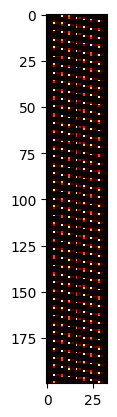

In [22]:
# Show a heatmap
plt.imshow(matrix[:200,17:50], cmap='hot', interpolation='nearest')

In [23]:
# Perform clustering
kmeans = KMeans(n_clusters=12, n_init='auto', verbose=100, random_state=100)
kmeans.fit(matrix)

Initialization complete
Iteration 0, inertia 107.2293473385345.
Iteration 1, inertia 95.30355038994216.
Iteration 2, inertia 93.59243128822773.
Iteration 3, inertia 92.27171097158853.
Iteration 4, inertia 91.32981282703244.
Iteration 5, inertia 90.70656463026612.
Iteration 6, inertia 90.11903242729987.
Iteration 7, inertia 89.74339173753714.
Iteration 8, inertia 89.36451055464146.
Iteration 9, inertia 89.17685592816663.
Iteration 10, inertia 88.99632655614485.
Iteration 11, inertia 88.81149015535689.
Iteration 12, inertia 88.67060860223256.
Iteration 13, inertia 88.59863076544545.
Iteration 14, inertia 88.53586949652195.
Iteration 15, inertia 88.47145355369052.
Iteration 16, inertia 88.43608474103111.
Iteration 17, inertia 88.39462741211733.
Iteration 18, inertia 88.37128956046547.
Iteration 19, inertia 88.35074030463406.
Iteration 20, inertia 88.33617564813933.
Iteration 21, inertia 88.32479550924718.
Converged at iteration 21: strict convergence.


KMeans(n_clusters=12, n_init='auto', random_state=100, verbose=100)

In [24]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids.shape, labels.shape)

(12, 93) (1925,)


In [25]:
sample_idxs = []
for label_idx in range(centroids.shape[0]):
    sample_idxes_near_cluster = np.argwhere(labels == label_idx).flatten()
    samples_near_cluster = matrix[sample_idxes_near_cluster,:]
    dists_from_centroid = np.linalg.norm(np.subtract(samples_near_cluster, centroids[label_idx]), axis=1)
    closest_sample_idx = np.argmin(dists_from_centroid)
    matrix_sample_idx = sample_idxes_near_cluster[closest_sample_idx]
    sample_idxs.append(matrix_sample_idx)

In [26]:
# Attempt to reconstruct IPC trace
gold_ipc_file = Path.cwd().parent.parent / "sims" / "vcs" / "ref_perf.csv"
gold_ipc = pd.read_csv(gold_ipc_file)
kmeans_model_file = Path.cwd() / "runs" / "aha-mont64-fb8c96bc" / "n_1000" / "c_12" / "kmeans.model"
with kmeans_model_file.open('rb') as f:
    kmeans_model = pickle.load(f)

In [66]:
# For every centroid sample, get the average IPC, excluding the first sample (consider the first 100 cycles as detailed warmup)
perf_files = [Path.cwd() / "runs" / "aha-mont64-fb8c96bc" / "n_1000" / "c_12" / "checkpoints" / "aha-mont64.loadarch" / f"0x80000000.{x*1000}" / "perf.csv" for x in sample_idxs]
sample_ipc_trace = []
for perf_file in perf_files:
    ipc_trace = pd.read_csv(perf_file)
    assert (ipc_trace['instret'].to_numpy()[:-1] == 100).all()
    sample_ipc_trace.append(100 / np.mean(ipc_trace['cycles'][1:-1]))

In [67]:
# Reconstruct the IPC trace from the labels for each sample
x_coords = []
y_coords = []
i = 0
for label in labels:
    x_coords.append(i)
    ipc = sample_ipc_trace[label]
    y_coords.append(ipc)
    x_coords.append(i+1000-1)
    y_coords.append(ipc)
    i = i + 1000

In [68]:
gold_x = []
gold_y = []
i = 0
for cycles in gold_ipc['cycles']:
    gold_x.append(i)
    gold_y.append(1000 / cycles)
    gold_x.append(i+1000-1)
    gold_y.append(1000 / cycles)
    i = i + 1000

In [69]:
gold_ipc

,cycles,instret
0,5490,1000
1,1186,1000
2,1386,1000
3,1342,1000
4,1176,1000
...,...,...
3835,1170,1000
3836,1242,1000
3837,1154,1000
3838,1216,1000


(500000.0, 600000.0, 0.4, 1.0)

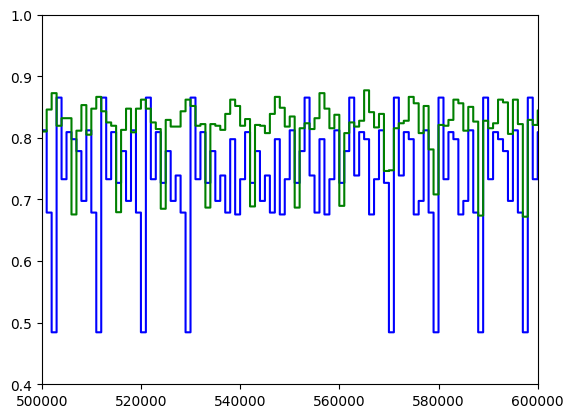

In [70]:
plt.plot(x_coords, y_coords, 'b')
plt.plot(gold_x, gold_y, 'g')
plt.axis([0.5e6, 0.6e6, 0.4, 1])